# Введение в ансамбли: бэггинг. Случайный лес

In [1]:
import numpy as np # для матричных вычислений
import pandas as pd # для анализа и предобработки данных
import matplotlib.pyplot as plt # для визуализации
import seaborn as sns # для визуализации

from sklearn import linear_model # линейные модели
from sklearn import tree # деревья решений
from sklearn import ensemble # ансамбли
from sklearn import metrics # метрики

from sklearn.model_selection import train_test_split

from sklearn import set_config
set_config(transform_output='pandas')

%matplotlib inline
plt.style.use('seaborn-darkgrid')
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (10, 8)

In [2]:
diabetes_data = pd.read_csv('data/diabetes_cleaned.zip')
diabetes_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,98.0,58.0,33.0,34.0,0.430,43,0
1,2,112.0,75.0,32.0,35.7,0.148,21,0
2,2,108.0,64.0,29.0,30.8,0.158,21,0
3,8,107.0,80.0,29.0,24.6,0.856,34,0
4,7,136.0,90.0,29.0,29.9,0.210,50,0


In [3]:
TARGET_FEATURE = 'Outcome'

## Бэггинг. Случайный лес (Random Forest)

По традиции сначала построим модель на двух признаках (Glucose и BMI) и посмотрим, как будет выглядеть разделяющая поверхность случайного леса.

In [4]:
# Создаем матрицу наблюдений X и столбец с ответами y
X = diabetes_data[['Glucose', 'BMI']]
y = diabetes_data[TARGET_FEATURE]

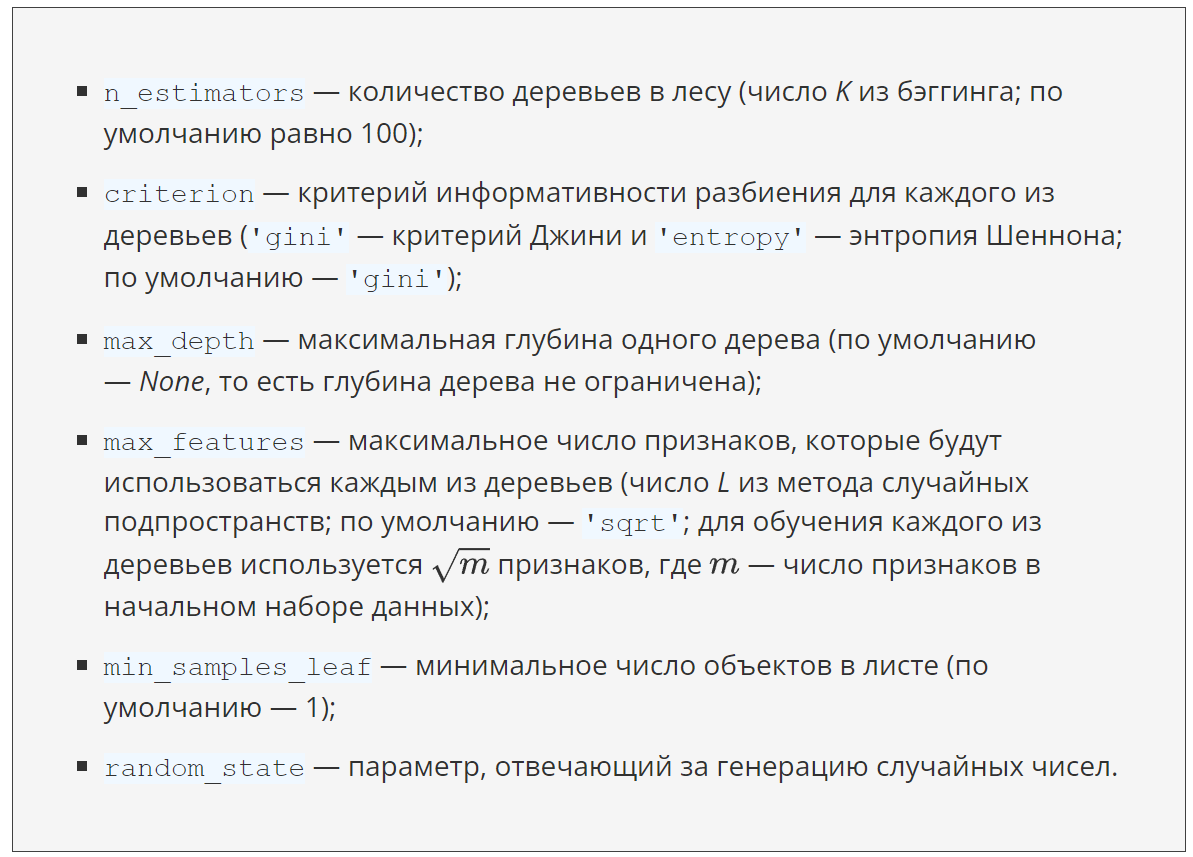

In [5]:
# Создаем объект класса случайный лес
rf_clf_2d = ensemble.RandomForestClassifier(
    n_estimators=500, # число деревьев
    criterion='entropy', # критерий эффективности
    max_depth=3, # максимальная глубина дерева
    max_features='sqrt', # число признаков из метода случайных подространств
    random_state=42 # генератор случайных чисел
)
# Обучаем модель 
rf_clf_2d.fit(X, y)

# Делаем предсказание класса
y_pred = rf_clf_2d.predict(X)

# Выводим отчет о метриках
print(metrics.classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.88      0.84       493
           1       0.73      0.57      0.64       264

    accuracy                           0.78       757
   macro avg       0.76      0.73      0.74       757
weighted avg       0.77      0.78      0.77       757



C:\Users\avvoy\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\avvoy\AppData\Local\Temp\ipykernel_21236\3980367954.py:26: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  colorbar = fig.colorbar(contour)


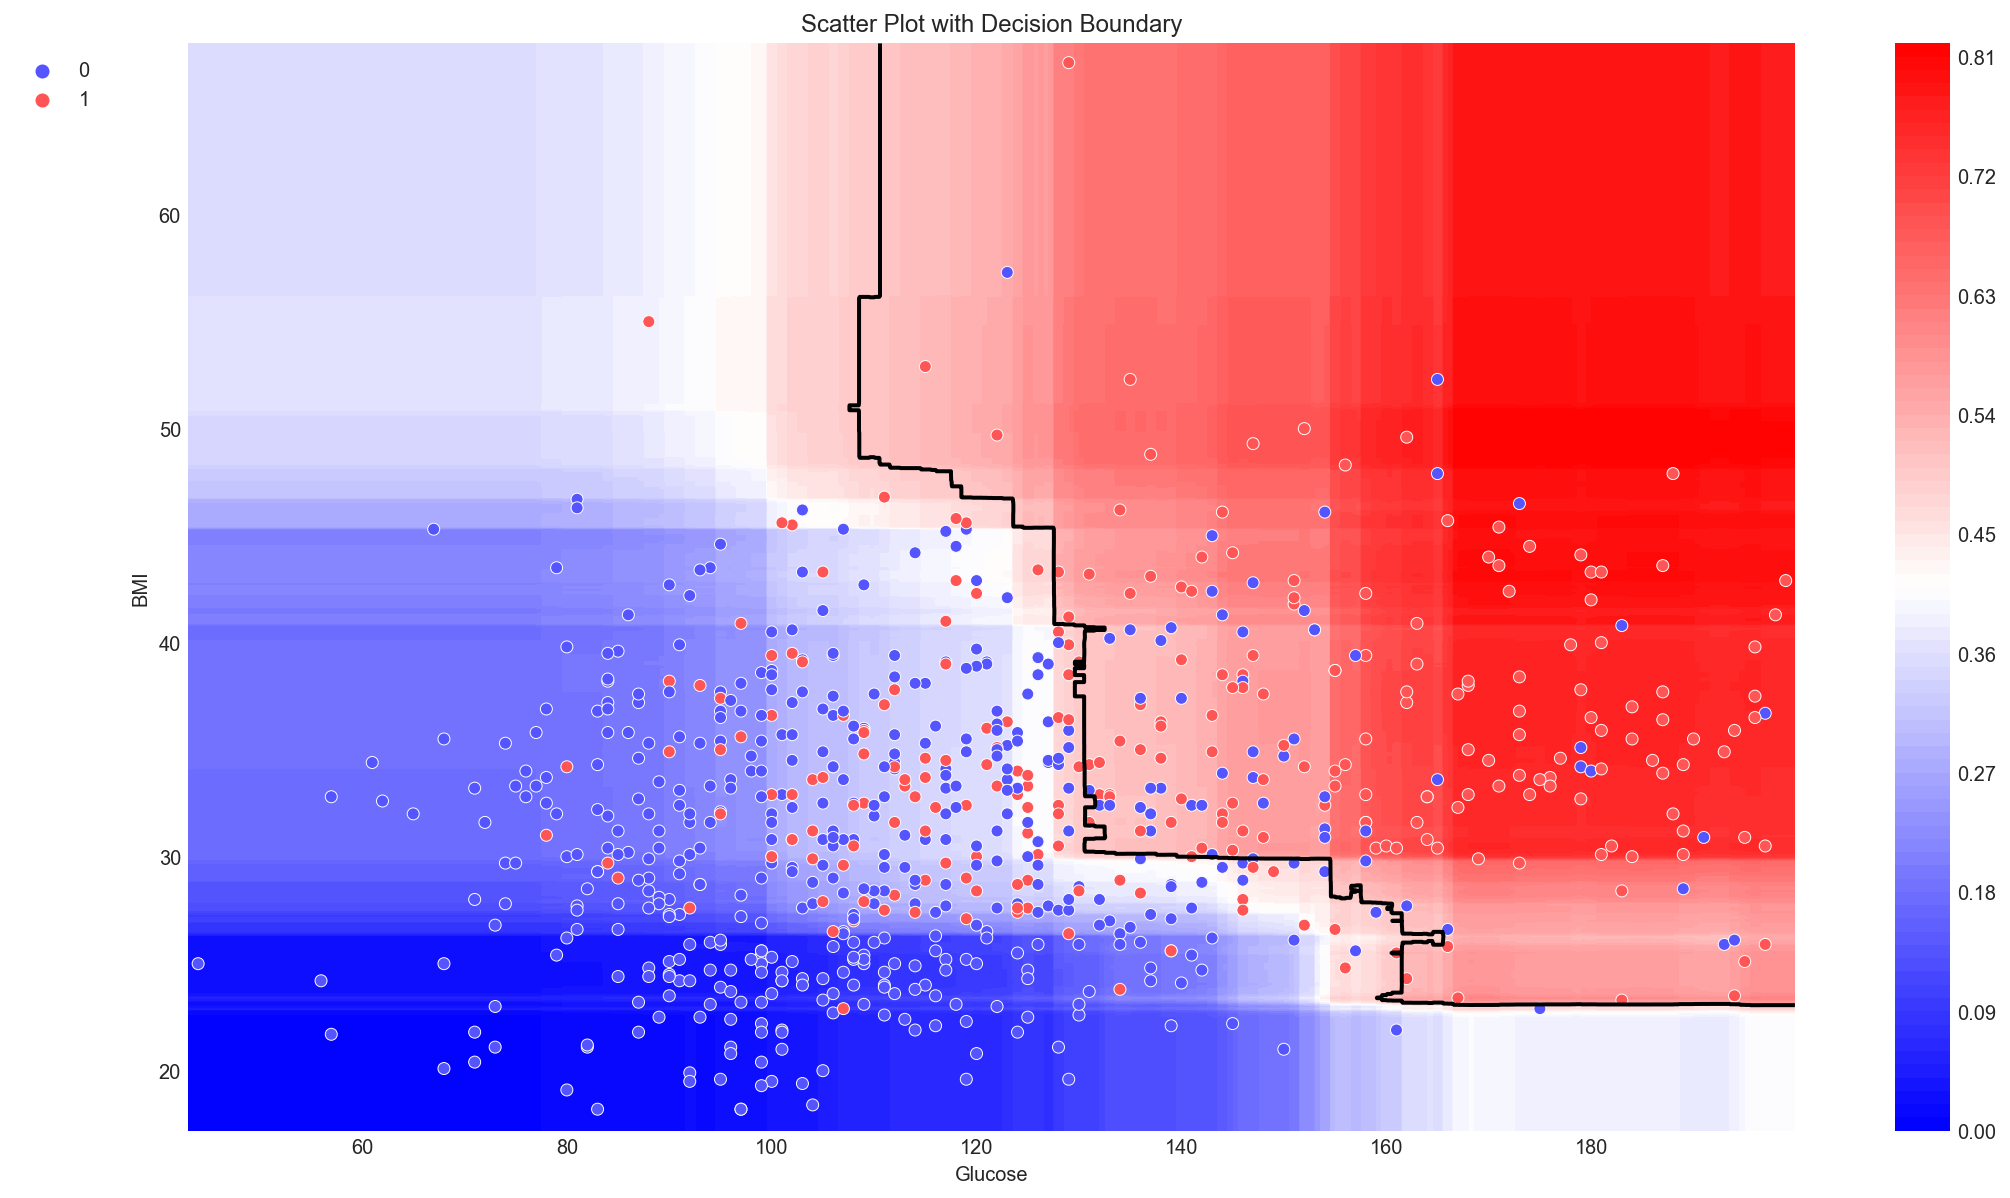

In [6]:
#Функция для визуализации модели
def plot_probabilities_2d(X, y, model):
    #Генерируем координатную сетку из всех возможных значений для признаков
    #Glucose изменяется от x1_min = 44 до x2_max = 199, 
    #BMI - от x2_min = 18.2 до x2_max = 67.1
    #Результат работы функции - два массива xx1 и xx2, которые образуют координатную сетку
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    #Вытягиваем каждый из массивов в вектор-столбец - reshape(-1, 1)
    #Объединяем два столбца в таблицу с помощью hstack
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    #Предсказывает вероятность для всех точек на координатной сетке
    #Нам нужна только вероятность класса 1
    probs = model.predict_proba(X_net)[:, 1]
    #Переводим столбец из вероятностей в размер координатной сетки
    probs = probs.reshape(xx1.shape)
    #Создаем фигуру и координатную плоскость
    fig, ax = plt.subplots(figsize = (18, 10))
    #Рисуем тепловую карту вероятностей
    contour = ax.contourf(xx1, xx2, probs, 100, cmap='bwr')
    #Рисуем разделяющую плоскость - линия, где вероятность равна 0.5
    bound = ax.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    #Добавляем цветовую панель 
    colorbar = fig.colorbar(contour)
    #Накладываем поверх тепловой карты диаграмму рассеяния
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette='seismic', ax=ax)
    #Даем графику название
    ax.set_title('Scatter Plot with Decision Boundary');
    #Смещаем легену в верхний левый угол вне графика
    ax.legend(bbox_to_anchor=(-0.05, 1))
plot_probabilities_2d(X, y, rf_clf_2d)

А теперь используем для предсказания все признаки из набора данных

In [7]:
# Создаем матрицу признаков X и столбец с ответами y
X = diabetes_data.drop(TARGET_FEATURE, axis=1)
y = diabetes_data[TARGET_FEATURE]

In [8]:
#Создаем объект класса случайный лес
rf_clf_full = ensemble.RandomForestClassifier(
    n_estimators=300, #число деревьев
    criterion='entropy', #критерий эффективности
    max_depth=6, #максимальная глубина дерева
    max_features='sqrt', #число признаков из метода случайных подространств
    random_state=42 #генератор случайных чисел
)
#Обучаем модель 
rf_clf_full.fit(X, y)

#Делаем предсказание класса
y_pred = rf_clf_full.predict(X)
#Выводим отчет о метриках
print(metrics.classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       493
           1       0.85      0.77      0.80       264

    accuracy                           0.87       757
   macro avg       0.86      0.85      0.85       757
weighted avg       0.87      0.87      0.87       757



Если мы захотим предсказывать не классы, а вероятности, чтобы, например, подобрать оптимальный порог вероятности, то сработает уже знакомый нам метод predict_proba():

In [12]:
rf_clf_full.predict_proba(X)

array([[0.7186633 , 0.2813367 ],
       [0.85222366, 0.14777634],
       [0.88358167, 0.11641833],
       ...,
       [0.28908312, 0.71091688],
       [0.44280536, 0.55719464],
       [0.94476689, 0.05523311]])

Однако так как случайный лес основан на деревьях решения, у него также есть атрибут feature_importances_, в котором находится коэффициенты важности каждого из признаков. Давайте построим столбчатую диаграмму, иллюстрирующую показатели важности для каждого признака.

In [9]:
rf_clf_full.feature_importances_

array([0.07236181, 0.3335561 , 0.05629632, 0.07408006, 0.20732916,
       0.10627658, 0.15009997])

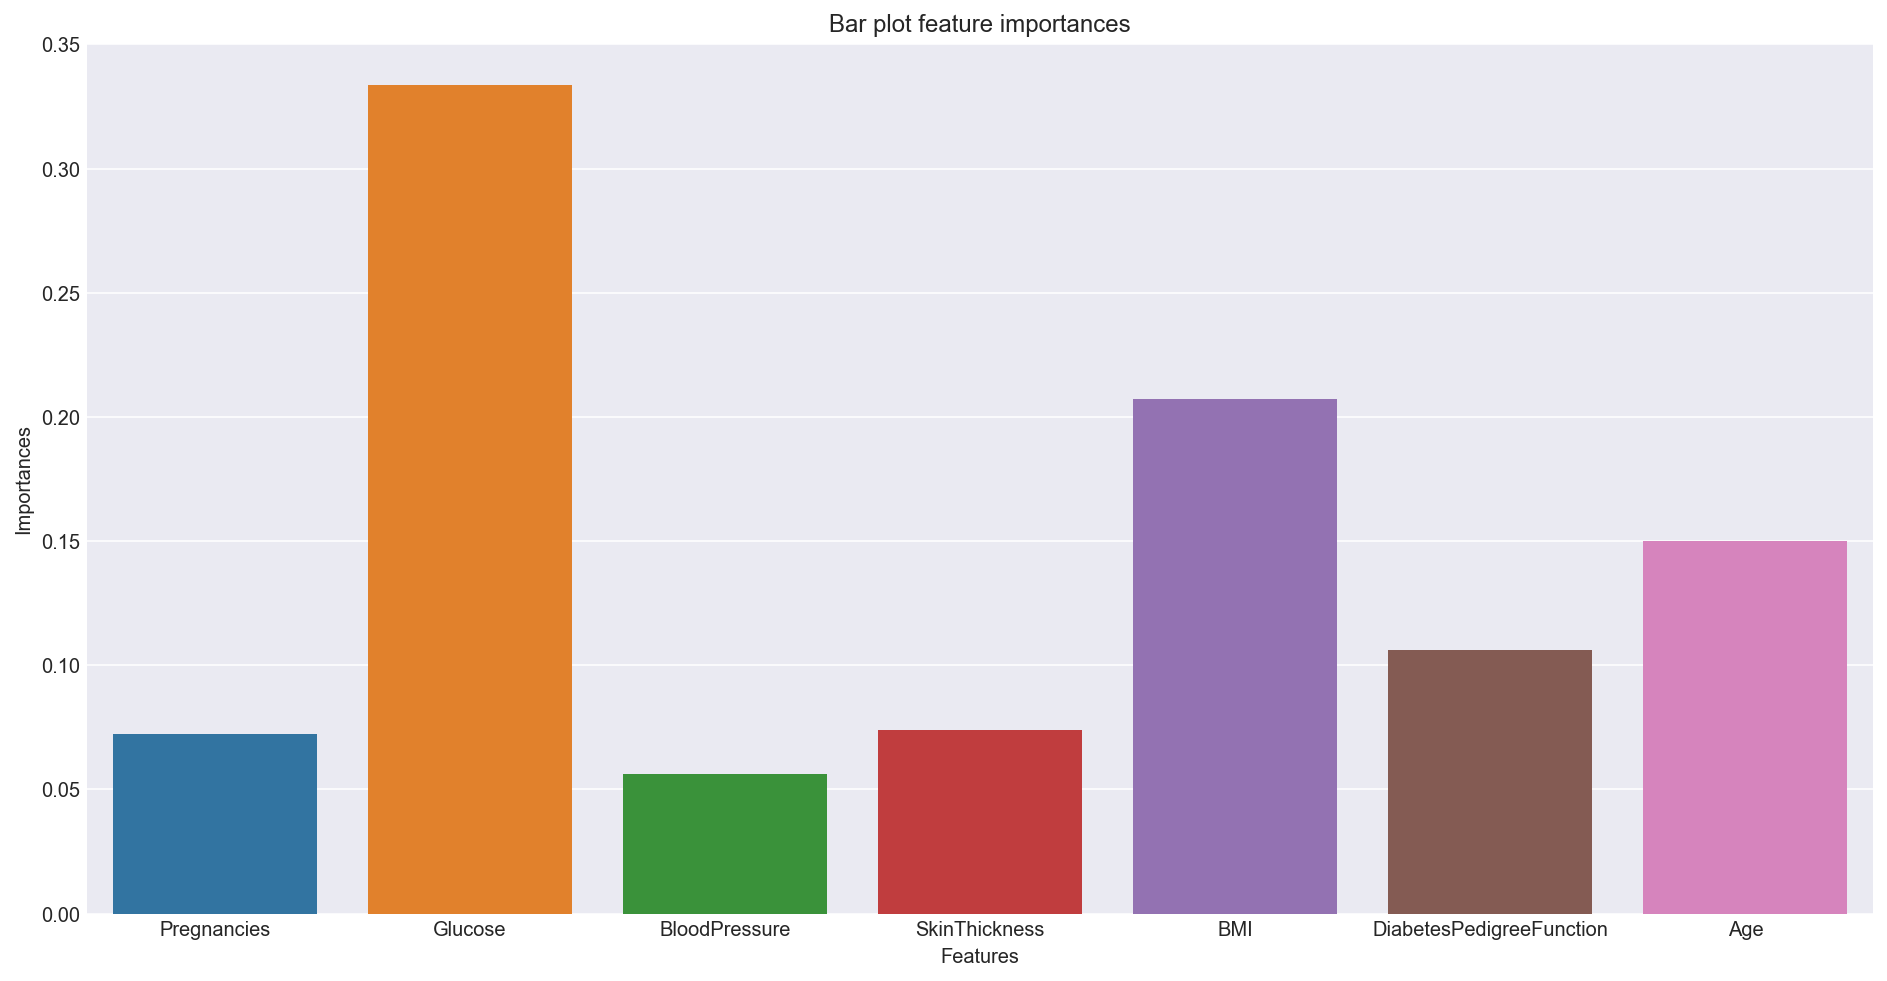

In [10]:
fig, ax = plt.subplots(figsize=(16, 8)) # фигура + координатная плоскость
feature = X.columns # признаки
feature_importances = rf_clf_full.feature_importances_ # важность признаков

# Строим столбчатую диаграмму
sns.barplot(x=feature, y=feature_importances, ax=ax)

# Добавляем подпись графику, осям абцисс и ординат
ax.set_title('Bar plot feature importances')
ax.set_xlabel('Features')
ax.set_ylabel('Importances');

Обратите внимание, что важность признаков для одного дерева и леса из деревьев могут отличаться. 

Случайный лес даёт более объективную картину об информативности признаков, так как информативность считается не по одному дереву, а по всей совокупности ансамбля.